# Statistical Methods - Assignment 2

All assignments are graded following the rubric on Canvas. In short, we are grading under the followings aspects: complete solution, explanation of assumptions, explanation of solution, clearness of plots, coding practices.

## Assignment 2:

|          |   Task 1    |    Task 2   |    Task 3   |    Task 4   |     Sum    |
|:--------:|:-----------:|:-----------:|:-----------:|:-----------:|:----------:|
| Solution |     4.5 / 5    |     4/ 5     |      4.5/ 5    |      4/ 5    |      17/ 20  |

- General comments: well done! :D Next time, pay extra attention to the assumptions, state them clearly, and comment on whether these are valid or not. For more details see below. 

In [1]:
from astropy.io import fits
import pandas as pd
import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.integrate as spint
import scipy.interpolate as spinterp
import warnings
from tabulate import tabulate

**Defining functions needed for various tasks**

In [2]:
def create_scplotmatrix(large_clusters,tasknum,pltitle):
    '''
    This function is used to create a matrix of scatter plots and histograms to show the variation of the parameters in 
    astromertric parametric space.

    Function parameters:
    ---------------------
    1. large_clusters:  Pandas dataframe
                        Dataframe of star clusters 
    2. tasknum : integer
                 Task number (we are creating different number of plots for task 1 and 4)
    3. pltitle : string
                 Plot title
    '''
    matplotlib.rc('xtick', labelsize=8) 
    matplotlib.rc('ytick', labelsize=8) 
    if(tasknum == 1):
        largecluster_array = np.column_stack((large_clusters['Mean_Parallax'], large_clusters['Sd_Parallax'], large_clusters['Mean Proper Motion'], large_clusters['Size'], large_clusters['Sd_ProperMotion']))
        ndims = 5
        labels = ['Mean Plx (mas)','Sd Plx (mas)','Mean PM (mas/yr)','Size (deg)','Sd_PM (mas/yr)']
    else : #in task 3 we are not plotting mean and standard deviation of parallax
        largecluster_array = np.column_stack((large_clusters['Mean Proper Motion'], large_clusters['Size'], large_clusters['Sd_ProperMotion']))
        ndims = 3
        labels = ['Mean PM (mas/yr)','Size (deg)','Sd_PM (mas/yr)']
    #Below is copied from extras of Prof. Uttley's github and modified
    fig, axes = plt.subplots(ndims,ndims,figsize=(10,10))
    fig.subplots_adjust(wspace=0.5,hspace=0.4)
    for i in range(ndims): ## y dimension
        for j in range(ndims): ## x dimension
            if i == j:
                axes[i,j].hist(largecluster_array[:,i], bins=20,alpha=0.5)
            elif i > j:
                axes[i,j].scatter(largecluster_array[:,j],largecluster_array[:,i],s=1)
            else:
                axes[i,j].axis('off')
            if j == 0:
                if i == j:
                    axes[i,j].set_ylabel('Counts',fontsize=11)
                else:
                    axes[i,j].set_ylabel(labels[i],fontsize=11)
            if i == (ndims-1):
                axes[i,j].set_xlabel(labels[j],fontsize=11)

    plt.suptitle(pltitle)            
    plt.show()

In [3]:
def calc_SpearPears(large_clusters,tasknum):
    '''
    Performs the Spearman and Pearson correlation tests for each of the combinations of astrometric parameters plotted in the scatter plot matrix.
    The correlation coefficients and p-values, along with the linear/monotonic relationship for each test are indicated in tabular format.
    
    Parameters:
    ------------
    1. large_clusters: Pandas dataframe
                       Dataframe of star clusters 
    2. tasknum : integer
                 Task number (we are doing different number of tests for task 2 and 4)
    '''
    if(tasknum == 2):
        var = ['Mean Plx', 'Sd Plx', 'Mean PM', 'Size', 'Sd_PM'] 
        largecluster_array = np.column_stack((large_clusters['Mean_Parallax'], large_clusters['Sd_Parallax'], large_clusters['Mean Proper Motion'], large_clusters['Size'], large_clusters['Sd_ProperMotion']))
        ndims = 5
    else :
        var = ['Mean PM', 'Size', 'Sd_PM']
        largecluster_array = np.column_stack((large_clusters['Mean Proper Motion'], large_clusters['Size'], large_clusters['Sd_ProperMotion']))
        ndims = 3
    #arrays to store Pearson and Spearman correlation coefficients and p-values
    Pearson_corr = np.zeros((len(var),len(var)))
    Pearson_pval = np.zeros((len(var),len(var)))
    Spearman_corr = np.zeros((len(var),len(var)))
    Spearman_pval = np.zeros((len(var),len(var)))
    Output_list = []
    for i in range(ndims): ## y dimension
        for j in range(ndims): ## x dimension
             if j > i:
                 Pearson_corr[i][j], Pearson_pval[i][j] = sts.pearsonr(largecluster_array[:,i],largecluster_array[:,j])
                 PearCorr = str("%.4g"%Pearson_corr[i][j])
                 PearPval = str("%.4g"%Pearson_pval[i][j])
                 #drawing conclusions based on p-value and correlation coefficient, explained in detail in markdown cell below
                 if(Pearson_pval[i][j] > 0.03):  
                     Pearson_inference = 'Cannot comment'
                 else:
                     if(Pearson_corr[i][j]>0.5):
                         Pearson_inference = 'Strong positive'
                     elif(Pearson_corr[i][j]<-0.5):
                         Pearson_inference = 'Strong negative'
                     elif(Pearson_corr[i][j]>0 and Pearson_corr[i][j]<0.5):
                         Pearson_inference = 'Weak positive'
                     else:
                         Pearson_inference = 'Weak negative'
                 Spearman_corr[i][j],Spearman_pval[i][j] = sts.spearmanr(largecluster_array[:,i],largecluster_array[:,j])
                 SpearCorr = str("%.4g"%Spearman_corr[i][j])
                 SpearPval = str("%.4g"%Spearman_pval[i][j])
                 if(Spearman_pval[i][j] > 0.03):
                     Spearman_inference = 'Cannot comment'
                 else:
                     if(Spearman_corr[i][j]>0.5):
                         Spearman_inference = 'Strong positive'
                     elif(Spearman_corr[i][j]<-0.5):
                         Spearman_inference = 'Strong negative'
                     elif(Spearman_corr[i][j]>0 and Spearman_corr[i][j]<0.5):
                         Spearman_inference = 'Weak positive'
                     else:
                         Spearman_inference = 'Weak negative'
                 Output = [var[i], var[j],PearCorr,PearPval, Pearson_inference,SpearCorr,SpearPval,Spearman_inference]
                 Output_list.append(Output) #each element of Output_list has the results for 1 combination of parameters
    #Used this to understand how to print the results in tabular form: https://stackoverflow.com/questions/9535954/printing-lists-as-tabular-data
    print(tabulate(Output_list, headers = ['Parameter 1', 'Parameter 2', 'Pearson Coefficient', 'Pearson p-value', 'Pearson Inference', 'Spearman Coefficient', 'Spearman p-value', 'Spearman Inference']))

In [4]:
def uni_posterior(newstardf):
    '''
    Computes the Bayesian posterior pdf for the distance (in kpc) to a cluster assuming a uniform prior pdf.
    
    Parameter:
    -----------
    1. newstardf: Pandas dataframe
                  Dataframe containing information of stars belonging to 1 cluster

    Returns:
    ---------
    1. Uni_posterior_pdf: numpy.ndarray
                          Posterior probability density function calculated using Bayes' theorem for distance to the cluster corresponding to newstardf
                          assuming a uniform prior
    '''
    
    #Some lines are modified version of code in Prof Uttley's github
    uni_prior = 1.0 #arbitrary uniform prior, the value only affects the probability density values, not the shape, median etc. of the pdf
    d_range = np.linspace(np.min(newstardf['Distance']),np.max(newstardf['Distance']),10000)
    Plx_array = np.array(newstardf['Plx'])
    e_array = np.array(newstardf['e_Plx'])
    #We need to reshape the arrays to column matrices so they are compatible with norm.logpdf
    res_ePlx = e_array.reshape(len(e_array),1)
    res_Plx = Plx_array.reshape(len(Plx_array),1)
    #Likelihood is calculated assuming parallax is normally distributed, reasonable by central limit theorem since a cluster has a large number of stars
    #Standard deviations are errors on individual parallax measurements
    #log scale is used as otherwise pdf values are extremely small and may be rounded to 0 by the program
    Uni_loglikel_prior = np.sum((sts.norm.logpdf(res_Plx, loc=1/d_range, scale = res_ePlx)),axis=0) + np.log(uni_prior) 
    # We can shift the function maximum to zero in log units, i.e. unity in linear units.
    # The shift is arbitrary, we just need to make the numbers manageable for the computer.
    Uni_likel_prior = np.exp(Uni_loglikel_prior-np.amax(Uni_loglikel_prior))
    Uni_likel_prior_int = spint.simpson(Uni_likel_prior, x = d_range) #evidence
    Uni_posterior_pdf = Uni_likel_prior/Uni_likel_prior_int

    return Uni_posterior_pdf

In [5]:
def real_posterior(newstardf):
    '''
    Computes the Bayesian posterior pdf for the distance (in kpc) to a cluster assuming a more realistic prior pdf given by 
    𝑑^2 e^-(d/L) where L = 1 kpc.
    
    Parameter:
    -----------
    1. newstardf: Pandas dataframe
                  Dataframe containing information of stars belonging to 1 cluster

    Returns:
    ---------
    1. Real_posterior_pdf: numpy.ndarray
                           Posterior probability density function calculated using Bayes' theorem for distance to the cluster corresponding to newstardf
                           assuming a realistic prior
    '''
    
    d_range = np.linspace(np.min(newstardf['Distance']),np.max(newstardf['Distance']),10000)
    real_prior = d_range**2 * np.exp(-np.abs(d_range)) 
    #not taking absolute values results in large negative distance values for some clusters with negative parallax values
    Plx_array = np.array(newstardf['Plx'])
    e_array = np.array(newstardf['e_Plx'])
    res_ePlx = e_array.reshape(len(e_array),1)
    res_Plx = Plx_array.reshape(len(Plx_array),1)
    Real_loglikel_prior = np.sum((sts.norm.logpdf(res_Plx, loc=1/d_range, scale = res_ePlx)),axis=0) + np.log(real_prior)
    Real_likel_prior = np.exp(Real_loglikel_prior-np.amax(Real_loglikel_prior))
    Real_likel_prior_int = spint.simpson(Real_likel_prior, x = d_range)
    Real_posterior_pdf = Real_likel_prior/Real_likel_prior_int

    return Real_posterior_pdf

In [6]:
def plot_posterior(UniPosterior, RealPosterior, NormalDistribution, dis_range, pltitle):
    '''
    Function used to plot the posterior pdfs calculated using Bayes' Theorem for distance to a cluster in kpc. The function plots posterior pdfs for
    both uniform and realistic priors, along with the normal distribution obtained by inverting mean parallax for the cluster and propogating standard
    error on parallax. The distance corresponding to the mode of the pdfs and 1 σ confidence intervals are also indicated in the plot.

    Parameters:
    ------------
    1. UniPosterior: numpy.ndarray
                     Posterior pdf obtained from uni_posterior
    2. RealPosterior: numpy.ndarray
                      Posterior pdf obtained from real_posterior
    3. NormalDistribution: numpy.ndarray
                           Normally distributed distance to the cluster, obtained by assuming inverse of mean parallax is distance to cluster and 
                           using standard error propogation for the standard deviation of distance
    4. dis_range: numpy.ndarray
                  (1d) array containing the distance range over which posterior pdf has been calculated, which is based on minimum and maximum parallax
                  of stars in the cluster
    5. pltitle : string                  
                 Plot title
    '''
    
    Mode_uniform_index = np.argmax(np.array(UniPosterior)) #finds the location of maximum value of posterior
    Mode_uniform = dis_range[Mode_uniform_index] #distance in kpc corresponding to maximum posterior
    Mode_real_index = np.argmax(np.array(RealPosterior))
    Mode_real = dis_range[Mode_real_index]
    #Code from Prof. Uttley's github to get confidence intervals
    Uni_cdf =  spint.cumulative_trapezoid(UniPosterior,dis_range,initial=0)
    Uni_ppf = spinterp.interp1d(Uni_cdf,dis_range)
    UniInt1sig = Uni_ppf([0.16,0.84]) #1-σ confidence interval, centred around 0.5 and a range of 0.68
    Real_cdf = spint.cumulative_trapezoid(RealPosterior,dis_range,initial=0)
    Real_ppf = spinterp.interp1d(Real_cdf,dis_range)
    RealInt1sig = Real_ppf([0.16,0.84])
    PlotInt = Uni_ppf([0.005,0.995]) #Distance range over which I am plotting, found by trial and error
    plt.figure()
    plt.plot(dis_range,UniPosterior,label='Uniform Prior',color='blue')
    plt.plot(dis_range,RealPosterior,label='Realistic Prior',color='red')
    plt.plot(dis_range,NormalDistribution,label='Normal distribution with error propogation', color = 'yellow')
    plt.axvline(Mode_uniform,color = 'green',linestyle = 'dashed', label = 'Mode-Uniform: '+str("%.4g"%Mode_uniform)+'kpc')
    plt.axvline(Mode_real,color = 'purple', linestyle = 'dashed', label = 'Mode-Realistic: '+str("%.4g"%Mode_real)+'kpc')
    plt.vlines(UniInt1sig, ymin =-0.1, ymax = 1.2*np.max(UniPosterior), color = 'grey', linestyle = 'dashdot', label = '1 \u03C3 confidence interval for uniform')
    plt.vlines(RealInt1sig, ymin =-0.1, ymax = 1.2*np.max(UniPosterior), color = 'pink', linestyle = 'dashdot', label = '1 \u03C3 confidence interval for real')
    plt.xlabel('Distance (kpc)')
    plt.ylabel('Probability Density (1/kpc)')
    plt.legend(fontsize='xx-small', loc='upper right')
    plt.title(pltitle)
    plt.xlim(PlotInt[0],PlotInt[1])
    plt.show()

In [7]:
def get_posterior(stardf, numstars = 1,plotflag=0):
    '''
    This is the function called in the main part of the code for tasks 3 and 4 to obtain posteriors and plot them if desired. It calls the functions
    uni_posterior, real_posterior and plot_posterior as required.

    Parameters:
    ------------
    1. stardf : Pandas dataframe
                Dataframe containing information of stars belonging to a cluster
    2. numstars: integer
                 Number of stars in the cluster for which posterior is being calculated. The default value of 1 means all stars in the cluster are used,
                 otherwise 10 stars are arbitrarily selected.
    3. plotflag: integer
                 Flag variable that enables plotting by calling plot_posterior if desired. 
                 Default value of 0 implies the posterior is not plotted.
    
    Returns:                 
    ---------
    1. Mode_real : float
                   Distance to the cluster in kpc calculated using the maximum value of the posterior pdf for a realistic prior,
    '''
    
    updatedstardf = stardf.copy()
    Clustername = updatedstardf.iloc[0,0]
    updatedstardf['Plx'] = updatedstardf['Plx'] + 0.029 #zero point offset
    updatedstardf['Distance'] = 1/updatedstardf['Plx']
    d_range = np.linspace(np.min(updatedstardf['Distance']),np.max(updatedstardf['Distance']),10000)
    Real_posterior = real_posterior(updatedstardf)
    if (plotflag == 1 and numstars == 1):
        Uniform_posterior = uni_posterior(updatedstardf)
        Mean_Plx = updatedstardf['Plx'].mean()
        Std_Plx = np.sqrt(1/np.sum(updatedstardf['e_Plx']**(-2)))
        Mean_Distance = 1/Mean_Plx
        Std_Distance = Std_Plx/Mean_Plx**2 #formula for standard deviation of distance by standard error propogation of parallax
        normaldist = sts.norm.pdf(d_range,loc = Mean_Distance, scale = Std_Distance)
        plottitle = 'Bayesian Posterior pdfs along with normal distribution pdf for ' + Clustername
        plot_posterior (Uniform_posterior,Real_posterior,normaldist,d_range, plottitle)
    if(numstars != 1): #we are always plotting for 10 stars
        starsample = updatedstardf.sample(n=10)
        distance_range_subsample = np.linspace(np.min(starsample['Distance']),np.max(starsample['Distance']),10000)
        Real_posterior_subsample = real_posterior(starsample)
        Uniform_posterior_subsample = uni_posterior(starsample)
        Mean_Plx = starsample['Plx'].mean()
        Std_Plx = np.sqrt(1/np.sum(starsample['e_Plx']**(-2)))
        Mean_Distance = 1/Mean_Plx
        Std_Distance = Std_Plx/Mean_Plx**2
        normaldist = sts.norm.pdf(distance_range_subsample,loc = Mean_Distance, scale = Std_Distance)
        plottitle = 'Bayesian Posterior pdfs along with normal distribution pdf for 10 stars of ' + Clustername  
        plot_posterior (Uniform_posterior_subsample,Real_posterior_subsample,normaldist,distance_range_subsample,plottitle)
        
    Mode_real_index = np.argmax(np.array(Real_posterior))
    Mode_real = d_range[Mode_real_index]
    return Mode_real

**Initial Setup- Loading the data from the given FITS file**

In [8]:
#copied from assignment
dr3stars = fits.open('../../Assignment 1/gaiadr3_cluster_stars.fits')
dr3stars.info()
#print(dr3stars[1].columns)
stars = pd.DataFrame(dr3stars[1].data)
stars['Name'] = stars['Name'].str.strip()

Filename: ../../Assignment 1/gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   


**Assignment Task 1**

In [9]:
stars_hiprob = stars[stars.Prob > 0.8]
clusters_hiprob = stars_hiprob.groupby(['Name']).size().reset_index(name='n_star')
clusters_sd_hiprob = stars_hiprob.groupby(['Name']).std(numeric_only=True).reset_index() 
clusters_mean_hiprob = stars_hiprob.groupby(['Name']).mean(numeric_only=True).reset_index()
clusters_hiprob['Mean_Parallax'] = clusters_mean_hiprob['Plx']
clusters_hiprob['Sd_Parallax'] = clusters_sd_hiprob['Plx']
clusters_hiprob['Size'] = np.sqrt(clusters_sd_hiprob['RAdeg']**2 + clusters_sd_hiprob['DEdeg']**2)
clusters_hiprob['Mean Proper Motion'] = np.sqrt(clusters_mean_hiprob['pmRA']**2 + clusters_mean_hiprob['pmDE']**2)
clusters_hiprob['Sd_ProperMotion'] = np.sqrt(clusters_sd_hiprob['pmRA']**2 + clusters_sd_hiprob['pmDE']**2)

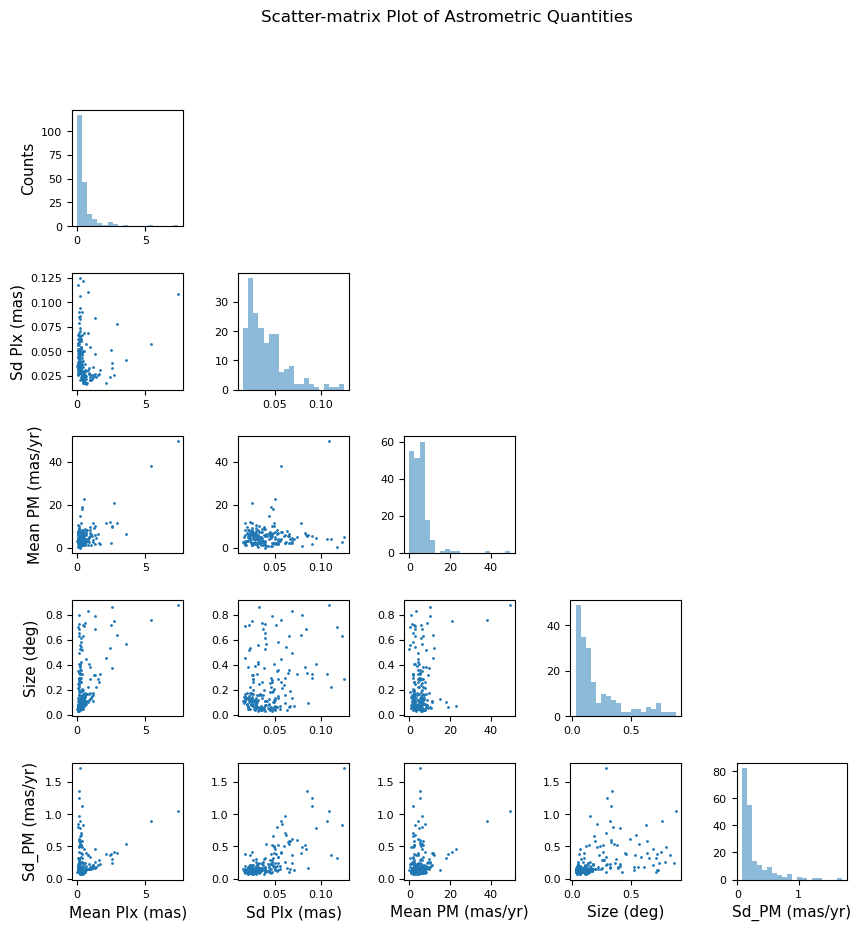

In [10]:
largeclusters_hiprob = clusters_hiprob[(clusters_hiprob['n_star'] > 200) & (clusters_hiprob['Size'] < 1)]
#Below line of code is from: https://stackoverflow.com/questions/54389006/pandas-how-to-transform-all-numeric-columns-of-a-data-frame-into-logarithms
#This is faster than my way of taking each column of clusters_hiprob, applying logarithm then filtering for more than 200 stars etc.
logclusters_hiprob = largeclusters_hiprob.apply(lambda x: np.log10(x) if np.issubdtype(x.dtype, np.number) else x) 
create_scplotmatrix(largeclusters_hiprob,1, 'Scatter-matrix Plot of Astrometric Quantities')

**Comments on Task 1**
<br>
The above plots are for clusters with more than 200 stars and a size less than 1 degree. The scatter plots do not show any clear correlations between the quantities. Most plots have peaks at lower X axis values, indicating that most clusters lie in a small range in terms of these parameters, with some large outliers (like clusters with more than 40 mas/yr proper motion). This is seen in the histograms as well, which have an exponential decay in counts. Furthermore, the mean parallax and mean proper motion do not appear to be correlated with the other quantities much, as the first and third column of scatter plots have a large range of y values for an x value. They do appear to be have a stronger correlation with each other however. This also seems true for their standard deviations, a somewhat linear relationship can be drawn between Sd_PM and Sd Plx. Finally, the size of the cluster does not seem to affect the other quantities.

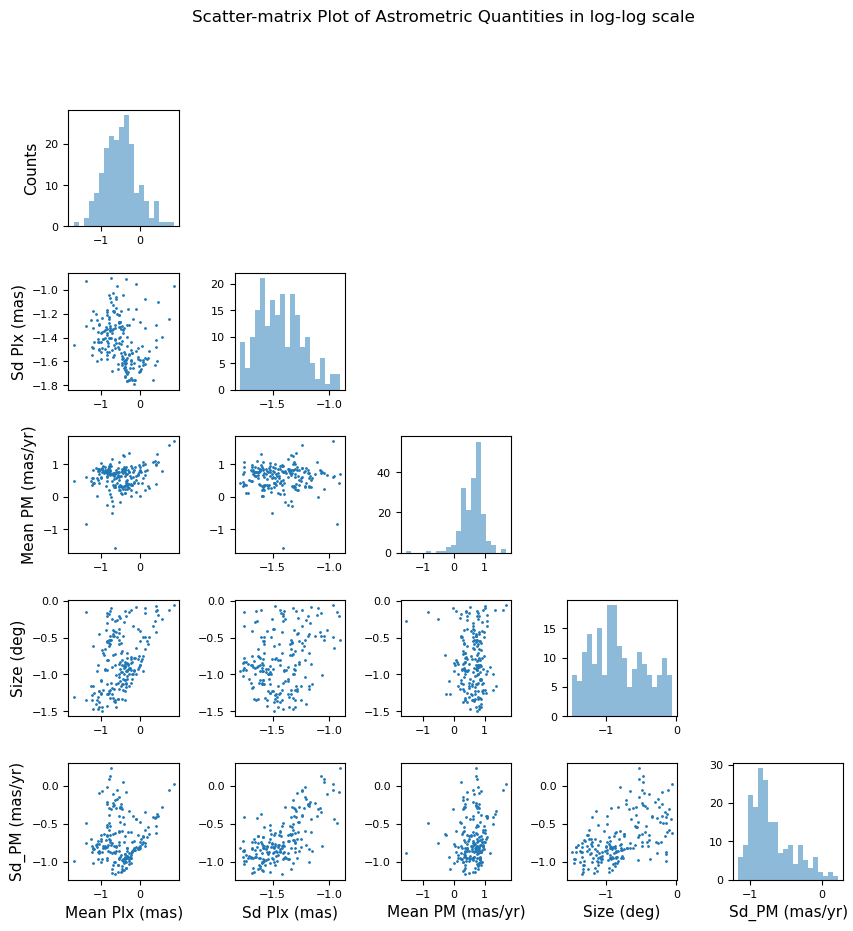

In [11]:
create_scplotmatrix(logclusters_hiprob,1, 'Scatter-matrix Plot of Astrometric Quantities in log-log scale')

**Comments on scatter matrix plots for log-transformed data**
<br>
Applying logarithm on the parameters greatly reduces the effect of the outliers. Firstly, we notice that all the histograms follow a normal distribution as expected, since we have ~200 clusters and central limit theorem applies. The correlations are now better visible, for example, we can see a decent linear relationship between the standard deviations of parallax and proper motion. The correlation between their means that I commented on above is also more pronounced. Finally, we can now see some correlations of parameters with cluster size, namely a somewhat positive monotonic relationship with mean parallax, and a marked positive relationship with the standard deviations of parallax and proper motion. This makes sense intuitively as well, a larger cluster should occupy more 'angular width' of the sky and the deviations would be larger too. 

*Mariska: well done! One important thing to notice in the linear scale plot is that some scatter plots appear to have two 'tracks'. This indicates that the might be more populations and that the i.i.d. assumption is not satisfied. Also, it is true that the distributions are more normally distributed in the log-scale plot. However, this is not because of the CLT (200 is still fairly small), but because the data itself is normally distributed.*

**Assignment Task 2**

In [12]:
#Wanted to highlight table title in bold so took some code from: https://stackoverflow.com/questions/8924173/how-can-i-print-bold-text-in-python
print('\033[1m Pearson and Spearman test results \033[0m'.center(150))
calc_SpearPears(largeclusters_hiprob,2)
print('\n')
print('\033[1m Pearson and Spearman test results for log-transformed data \033[0m'.center(150))
calc_SpearPears(logclusters_hiprob,2)

                                                      Pearson and Spearman test results                                                       
Parameter 1    Parameter 2      Pearson Coefficient    Pearson p-value  Pearson Inference      Spearman Coefficient    Spearman p-value  Spearman Inference
-------------  -------------  ---------------------  -----------------  -------------------  ----------------------  ------------------  --------------------
Mean Plx       Sd Plx                       0.04761          0.5054     Cannot comment                    -0.3762             4.712e-08  Weak negative
Mean Plx       Mean PM                      0.6685           5.222e-27  Strong positive                    0.05129            0.473      Cannot comment
Mean Plx       Size                         0.4766           1.276e-12  Weak positive                      0.3736             5.897e-08  Weak positive
Mean Plx       Sd_PM                        0.2285           0.001206   Weak positive    

**Comments on task 2**
<br>
The Pearson correlation coefficient measures linear relationship between 2 datasets, while Spearman measures the degree of monotonicity. The p-values for these tests are used to judge the possibility of a particular correlation coefficient being obtained from an actually uncorrelated dataset. Here, my 'null hypothesis' is that quantities are strongly positively correlated if they have a correlation coefficient greater than 0.5 and weakly correlated if less than 0.5 (and similarly for negative correlation). I have assumed a significance level α of 0.03 (2-σ). So the null hypothesis is rejected for p-values larger than 0.03 (traditionally the hypothesis is rejected below the α, but this is more convenient to use because of how the Spearman and Pearson methods in scipy.stats work). 

The tables above lists the conclusions we can draw for each combination of parameters. There are many significant results to be noted, so I will first discuss the table for original data. Firstly, almost all the correlations that can be commented on are positive. The Pearson test especially greatly agrees with the scatter-matrix plots, for instance the strong positive linear relationships between the means of parallax and proper motion as well as the standard deviations. The correlations with size are weak as expected. The Spearman test does not appear to be an appropriate test because most results have a high p-value. It does however mostly agree with the cases of strong positive relationships seen in Pearson. This does make sense because the Spearman is a rank-order correlation, and astrometric parameters don't really have a priority list (unlike say features of athletes).

The log-transformed data also gives some interesting results. Here, there is more agreement between the scatter-matrix plots and correlation coefficients, for example size and Sd_PM. Log transformation makes the results more reliable as any addition to correlation due to outliers is reduced. There is a negative correlation between the mean and standard deviation of parallax which I am unsure of how to explain. My best guess is that since standard deviation is calculated using the mean, and there are squares and square roots involved, taking the logarithm causes this negative effect. Finally, the results for Spearman are identical for both datasets, which is expected since it is rank-based and the rank is already a transformation on the data, so logarithm does not have an effect.

*Mariska: well done commenting on your results. What is missing the an epxlanation of whether the tests you used are appropriate by stating the assumptions and assess whether these are valid (by looking at the plots and the number of samples). Having a high p-value is not an indication that your test is appropriate, it simply means that you keep your null hypothesis.*

**Assignment Task 3**

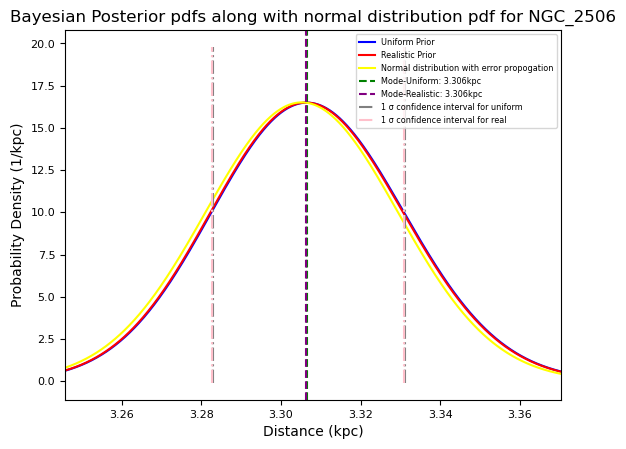

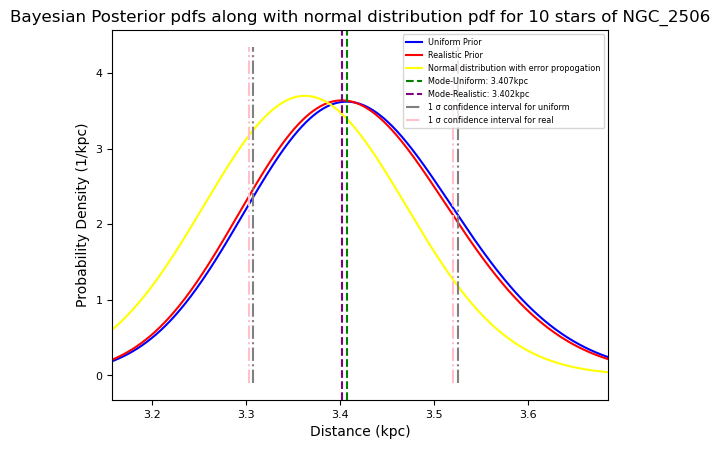

In [13]:
specific_cluster = largeclusters_hiprob[largeclusters_hiprob['Name']=='NGC_2506']
stars_specificl = stars_hiprob.loc[stars_hiprob['Name'].isin(specific_cluster['Name'])]
dist1 = get_posterior(stars_specificl,1,1)
dist2 = get_posterior(stars_specificl,10,1)

#For TA: Uncomment below lines if you would like to see this for a randomly generated cluster
#Note that you may have to comment out the plt.xlims line in plot_posterior 
# random_cluster = largeclusters_hiprob.sample(n=1)
# stars_randomcl = stars_hiprob.loc[stars_hiprob['Name'].isin(random_cluster['Name'])]
# get_posterior(stars_randomcl,1,1)
# get_posterior(stars_randomcl,10,1)



**Comments on Task 3**
<br>
For this task, I have selected the cluster NGC_2506, although I have made provisions in the code to use any cluster from the ~200 clusters with more than 200 stars and size less than 1 degree. The plots show Bayesian posterior pdfs for distance to the cluster in kpc for both a uniform prior and a more realistic prior. Here, distance is taken to be the reciprocal of parallax (in mas)The yellow line indicates how the distance distribution would look if it was a normal distribution centred around the inverse of the mean parallax of the cluster and a width corresponding to the standard deviation obtained by standard error propogation on the parallax. Using the formula given in Prof. Uttley's github for standard error propogation, we get $\sigma_d$ = $\sigma_P$/${\mu_P^2}$, where $\sigma_d$ and $\sigma_P$ are the standard deviations of distance and parallax, and $\mu_P$ is the mean of the parallax. Standard deviation of parallax is obtained using the errors on individual parallax measurements. Finally, the plots also indicate the distance corresponding to maximum value of posterior probability density and 1 $\sigma$ confidence intervals for the distance.

The first plot for all stars in NGC_2506 has all 3 probability density functions almost overlapping. The 2 bayesian pdfs are expected to overlap since there are a large number of stars in the cluster and we take a large number of points in the distance range array, so central limit theorem applies (we are also assuming i.i.d dataset). The normal distribution overlap however is a coincidence (and zooming in would indicate that the peaks are actually different). This is more apparent in clusters like Bochum_10. The non-overlap can be explained as the datasets not being truly independent and identically distributed, or the sample size not being large enough, or the choice of priors affecting the peak position. The reality in some clusters may be that some stars are more grouped up, so the distance to the cluster is actually different depending on if we assume it to be the mean or if we take it to be the one from Bayes' theorem calculations where each star's parallax is taken into consideration.

The second plot for a random subsample of 10 stars in NGC_2506 demonstrates the effect of smaller sample size. The 2 Bayesian posteriors no longer overlap, and the normal distribution mean is quite far off from the modes of the Bayesian pdfs. The widths of the posteriors are also much larger (~0.2 kpc in this case and only ~0.05kpc for the first plot) as there is more deviation from a normal distribution. One small observation that I have made from seeing multiple subsample plots is that the uniform prior mode is always greater than that of the realistic prior by about 0.005 kpc, likely because the exponential part of the realistic prior plays a larger role in a smaller sample size. 

*Mariska: very well done!! The non-overlap between the two distribution between the priors for a large sample is simply because the priors affect the distribution (this effect is larger for smaller samples when the prior becomes more dominant). It is not because of i.i.d. Regarding the normal distribution, this is different from the other two distributions because since the sample mean is a biased estimator of the mean for normally distributed data (the weighted mean is unbiased).*

**Assignment Task 4**

In [14]:
#I have added the below line because there are some runtime warnings caused by the negative parallaxes in some clusters
warnings.filterwarnings('ignore')  #https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings
ClusterDistance_array = np.zeros(len(largeclusters_hiprob))
for i in range(len(largeclusters_hiprob)):
    clname = largeclusters_hiprob.iloc[i]['Name']
    starcl = stars_hiprob.loc[stars_hiprob['Name'] == clname]
    ClusterDistance_array[i] = get_posterior(starcl,1,0)

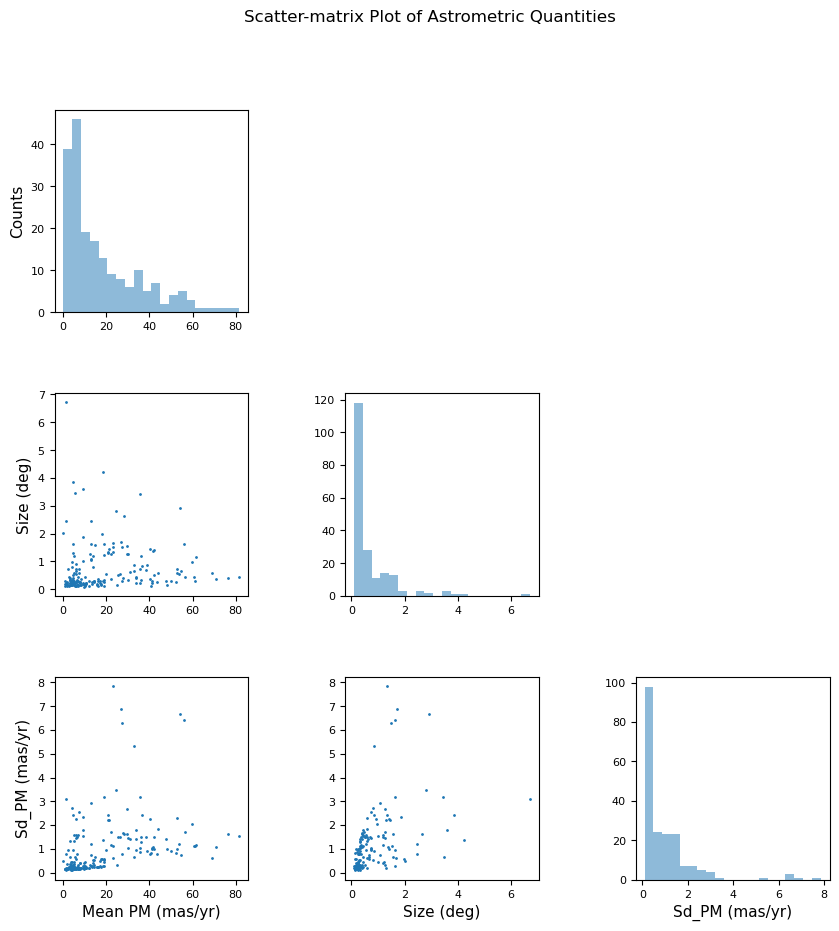

                                                      Pearson and Spearman test results                                                       
Parameter 1    Parameter 2      Pearson Coefficient    Pearson p-value  Pearson Inference      Spearman Coefficient    Spearman p-value  Spearman Inference
-------------  -------------  ---------------------  -----------------  -------------------  ----------------------  ------------------  --------------------
Mean PM        Size                         0.08708          0.2225     Cannot comment                       0.3563           2.577e-07  Weak positive
Mean PM        Sd_PM                        0.3866           1.843e-08  Weak positive                        0.593            3.433e-20  Strong positive
Size           Sd_PM                        0.4932           1.554e-13  Weak positive                        0.7343           8.12e-35   Strong positive


In [15]:
distcorr_df = largeclusters_hiprob.copy()
distcorr_df['Mean_Parallax'] = 1.0 #Since we are assuming the clusters to be at a distance of 1 kpc, parallax = 1/d = 1.0 mas
distcorr_df['Sd_Parallax'] = 0.0 #Distance and hence parallax is fixed, and a fixed quantity has no standard deviation. 
#I asked a TA and he said I am allowed to ignore Sd_Parallax and scale and work with the other 3 observed quantities. 
distcorr_df['Size'] = distcorr_df['Size'] * ClusterDistance_array
distcorr_df['Mean Proper Motion'] = distcorr_df['Mean Proper Motion'] * ClusterDistance_array
distcorr_df['Sd_ProperMotion'] = distcorr_df['Sd_ProperMotion'] * ClusterDistance_array
create_scplotmatrix(distcorr_df,4,'Scatter-matrix Plot of Astrometric Quantities')
print('\033[1m Pearson and Spearman test results \033[0m'.center(150))
calc_SpearPears(distcorr_df,4)

**Comments on task 4**
<br>
The above scatter plots and histograms show the relationship between the astrometric parameters when they are scaled assuming the clusters are at a fixed distance of 1kpc. Since distance = 1/parallax, this makes the mean parallax 1 mas and there is no standard deviation on parallax as it is a fixed quantity. Hence, I have only plotted the other three after scaling them in all clusters. The Pearson and Spearman tests are also for combinations of these 3 are correlations with the parallax are not applicable.

From the above results, we can see a much better correlation between the quantities, both from the plots themselves where for instance the Sd_PM vs Size plot depicts a linear relation, as well as the correlation coefficients. The Spearman test is also giving robust results, perhaps due to the scaling to 1 kpc resulting in a sort of 'even playing field'. It makes sense that the correlations would be better as a good amount of clusters have been 'brought closer'.

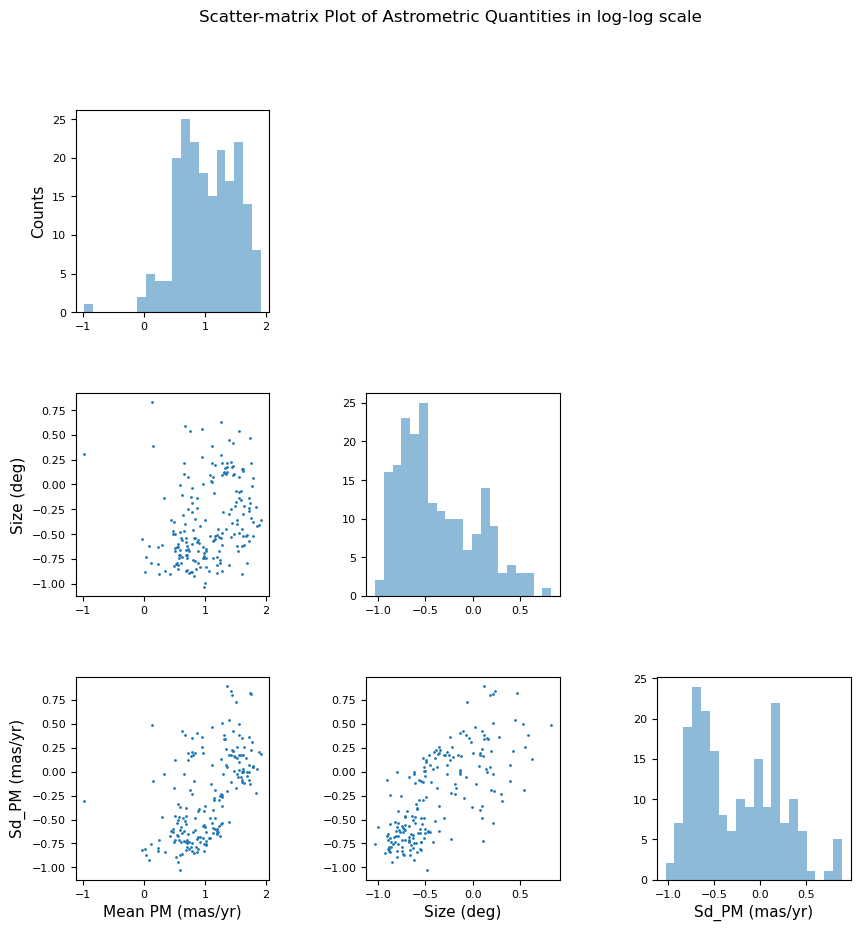

                                          Pearson and Spearman test results for log-transformed data                                          
Parameter 1    Parameter 2      Pearson Coefficient    Pearson p-value  Pearson Inference      Spearman Coefficient    Spearman p-value  Spearman Inference
-------------  -------------  ---------------------  -----------------  -------------------  ----------------------  ------------------  --------------------
Mean PM        Size                          0.2548          0.0002911  Weak positive                        0.3563           2.577e-07  Weak positive
Mean PM        Sd_PM                         0.5636          5.372e-18  Strong positive                      0.593            3.433e-20  Strong positive
Size           Sd_PM                         0.7114          7.462e-32  Strong positive                      0.7343           8.12e-35   Strong positive


In [16]:
logdistcorr_df = distcorr_df.apply(lambda x: np.log10(x) if np.issubdtype(x.dtype, np.number) else x) 
create_scplotmatrix(logdistcorr_df,4,'Scatter-matrix Plot of Astrometric Quantities in log-log scale')
print('\033[1m Pearson and Spearman test results for log-transformed data \033[0m'.center(150))
calc_SpearPears(logdistcorr_df,4)

**Comments on log-transformed data**
<br>
These results are now even more reliable as the outliers have also been eliminated. This is apparent from the very low p-values and high correlation coefficients in the Pearson test results. It is also more visible in all the scatter plots.

*Mariska: your plots look good and you mostly have a correct explanation. It is true that the results are more reliable, but the main reason for that is that the bivariate distributions also appear smoother, so the data is more likely to be i.i.d. which adds confidence to the correlations. That said, there are some outliers in proper motion, and this means that the Spearman test gives a greater significance than the Pearson test in those cases, since it is much less sensitive to outliers. Also, always clearly state your assumptions!*

*The standard deviation scales with the inverse of the distance as well and isn't zero. But this might have been a misunderstanding with Niek and we don't substract points for only plotting 3 parameters. He will explain on Friday :)*